In [41]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

Text(0.5, 1.0, 'Mask')

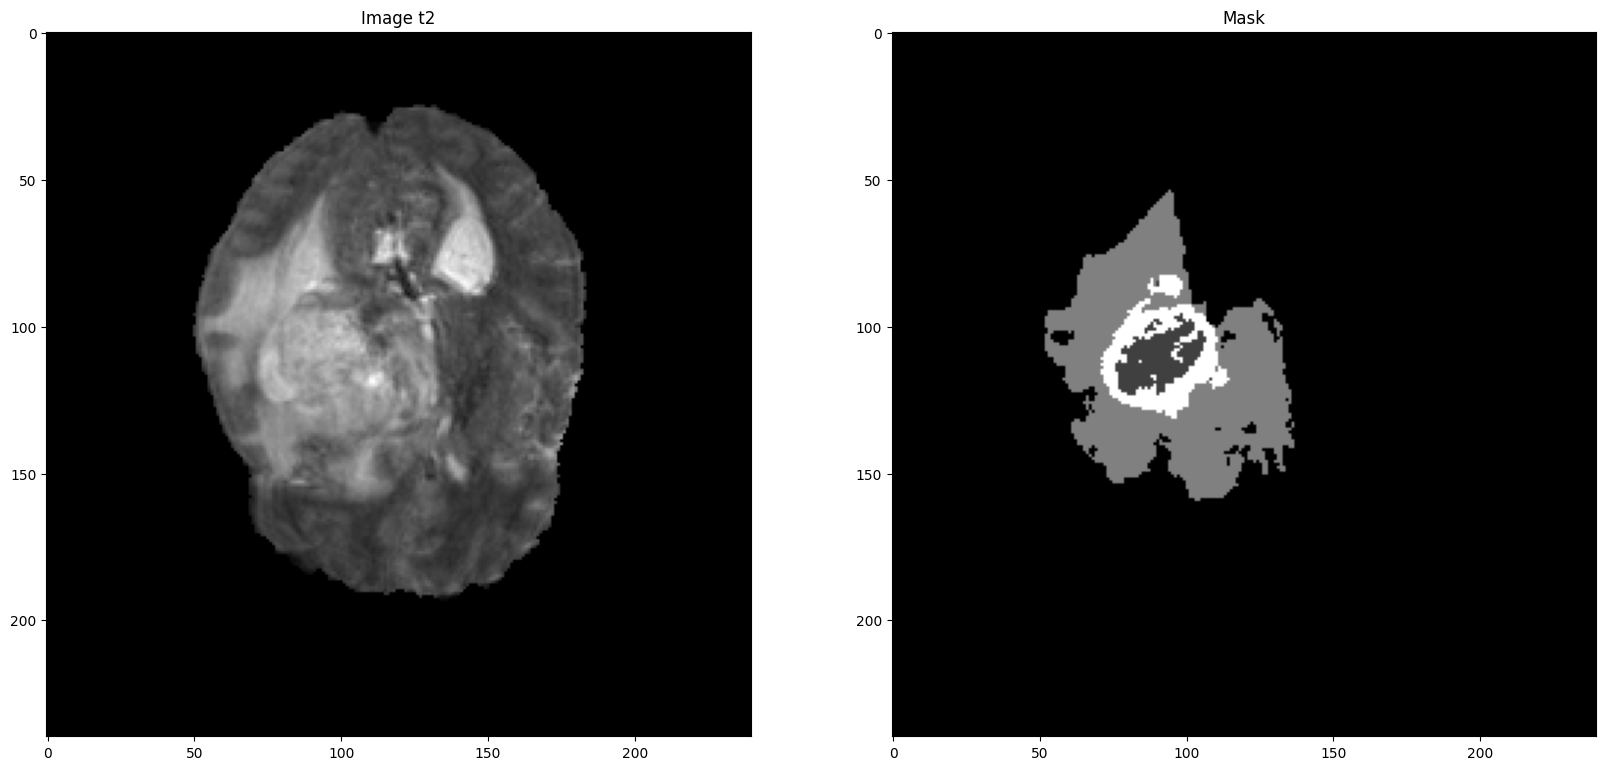

In [42]:
TRAIN_DATASET_PATH = 'data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

slice_w = 70

test_image_t2 = np.rot90(nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata(), 1)[:, :, slice_w]
test_mask=np.rot90(nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata(), 1)[:, :, slice_w]

fig, axs = plt.subplots(1,2, figsize = (20, 10))
axs[0].imshow(test_image_t2, cmap = 'gray')
axs[0].set_title('Image t2')
axs[1].imshow(test_mask, cmap = 'gray')
axs[1].set_title('Mask')


In [43]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

TRAIN_DATASET_PATH = 'data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

def find_max_necrotic(seg_image):
    # Initialize variables to keep track of max count and index
    max_count = 0
    max_idx = 0

    # Loop through all slices and count number of pixels with value 1
    for i in range(seg_image.shape[2]):
        count = np.count_nonzero(seg_image[:, :, i] == 1)
        if count > max_count:
            max_count = count
            max_idx = i
    return max_idx

def preprocess_dataset(dataset_path):

    folder_names = os.listdir(dataset_path)
    images = np.empty((len(folder_names), 240, 240, 1), dtype=np.uint8)
    masks = np.empty((len(folder_names), 240, 240, 1), dtype=np.uint8)

    for i, folder_name in enumerate(folder_names):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                seg_path = os.path.join(folder_path, f'{folder_name}_seg.nii')
                t2_path = os.path.join(folder_path, f'{folder_name}_t2.nii')
                if os.path.exists(t2_path) and os.path.exists(seg_path):

                    seg_image = np.rot90(nib.load(seg_path).get_fdata(), 1)
                    t2_image = np.rot90(nib.load(t2_path).get_fdata(), 1)
                    
                    slice_index = find_max_necrotic(seg_image)
                    
                    t2_image[:, :, slice_index] = (t2_image[:, :, slice_index] / np.max(t2_image[:, :, slice_index]) * 255).astype(np.uint8)
                    images[i,:,:,0] = t2_image[:, :, slice_index]
                    masks[i,:,:,0] = seg_image[:, :, slice_index]
    return images, masks

In [44]:
def create_enhance_masks(masks):
    new_masks = np.where((masks == 1) | (masks == 4), 256, 0)
    new_masks[masks == 2] = 0
    return new_masks

def create_necrotic_masks(masks):
    new_masks = np.where((masks == 2) | (masks == 4), 0, 0)
    new_masks[masks == 1] = 256
    return new_masks

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i], cmap='gray')
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1], cmap='gray')
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2], cmap='gray')
        
        plt.show()

In [77]:
images, masks = preprocess_dataset(TRAIN_DATASET_PATH)

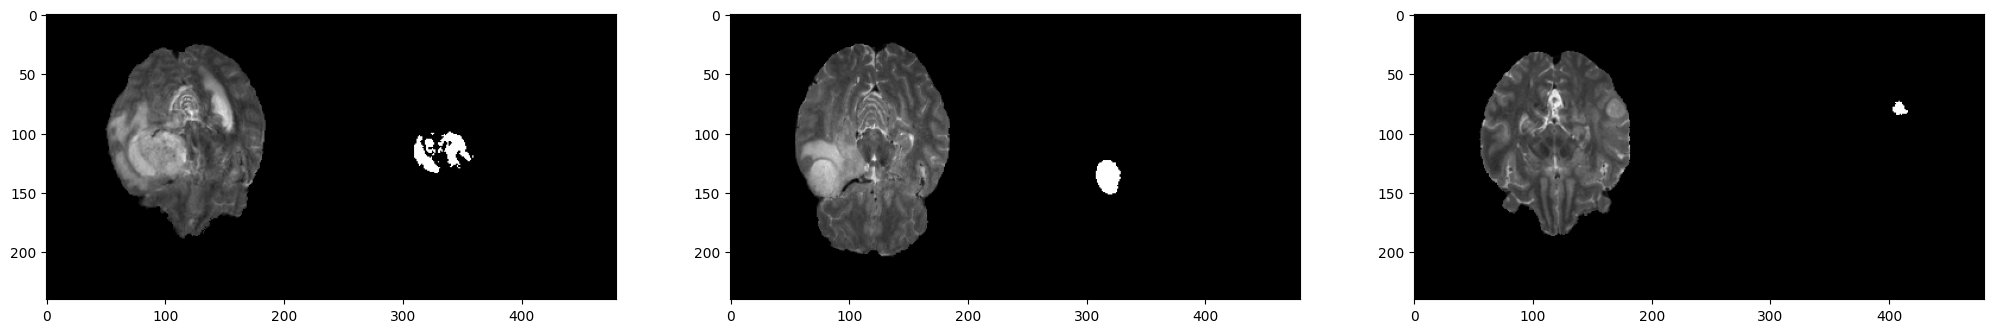

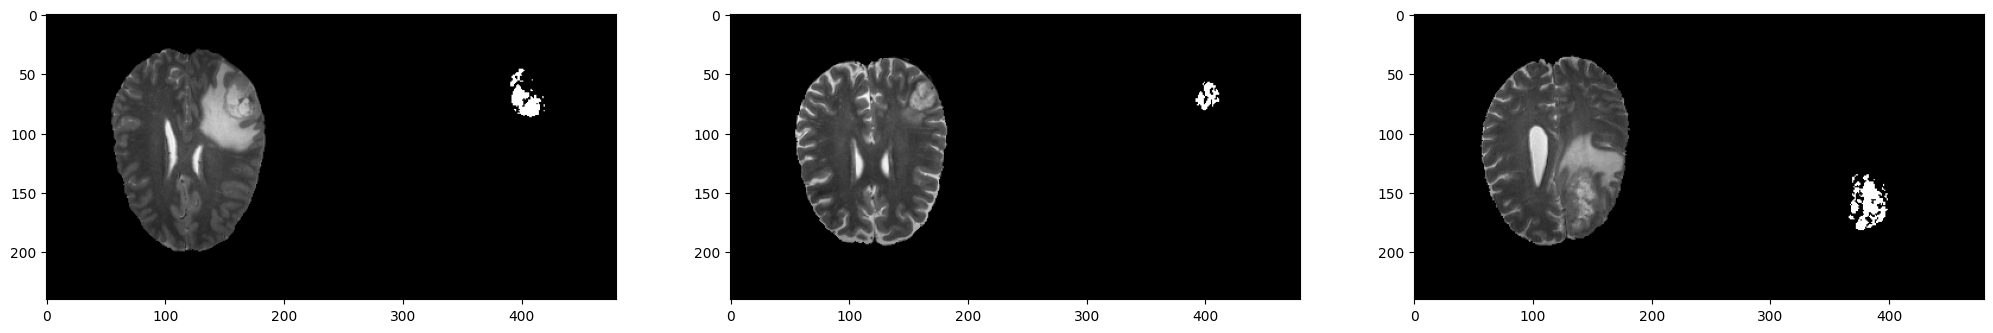

In [78]:
enhance_masks = create_enhance_masks(masks)
necrotic_masks = create_necrotic_masks(masks)
plotMask(images,necrotic_masks)

In [79]:
dim = 240
features = np.array(images).reshape(len(images),dim,dim,1)
labels = np.array(necrotic_masks).reshape(len(necrotic_masks),dim,dim,1)

In [48]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from IPython.display import clear_output

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [49]:
model = unet(input_size=(240,240,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()
clear_output()

In [50]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [82]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

train_vol, validation_vol, train_seg, validation_seg = train_test_split((features-127.0)/127.0, 
                                                            (labels>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 42)

d, validf, dd, validl = train_test_split(images, masks, test_size = 0.1,random_state = 42)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 42)


In [52]:
model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 15,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: -0.0287 - dice_coef: 0.0285 - binary_accuracy: 0.5950
Epoch 1: val_loss improved from inf to -0.02749, saving model to cxr_reg_weights.best.hdf5
19/19 [==============================] - 130s 7s/step - loss: -0.0287 - dice_coef: 0.0285 - binary_accuracy: 0.5950 - val_loss: -0.0275 - val_dice_coef: 0.0255 - val_binary_accuracy: 0.8961 - lr: 2.0000e-04
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: -0.0454 - dice_coef: 0.0455 - binary_accuracy: 0.8783
Epoch 2: val_loss improved from -0.02749 to -0.06854, saving model to cxr_reg_weights.best.hdf5
19/19 [==============================] - 123s 6s/step - loss: -0.0454 - dice_coef: 0.0455 - binary_accuracy: 0.8783 - val_loss: -0.0685 - val_dice_coef: 0.0612 - val_binary_accuracy: 0.9091 - lr: 2.0000e-04
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: -0.2768 - dice_coef: 0.2822 - binary_accuracy: 0.9580
Epoch 3: val_loss improved from -

In [57]:
model.save("model_necrotic_15.h5")

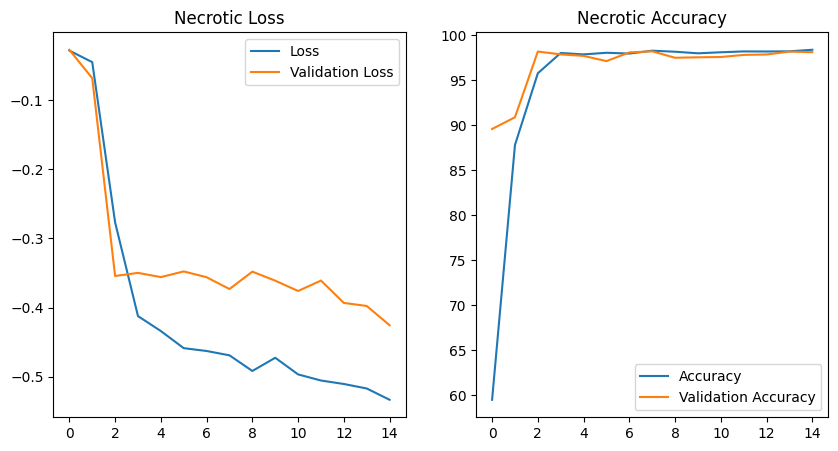

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()
ax1.set_title('Necrotic Loss')

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.set_title('Necrotic Accuracy')
ax2.legend()

In [58]:
from keras import models

model_enhance = models.load_model('model_enhanced_15.h5', 
                                   custom_objects={ "dice_coef": dice_coef
                                                  }, compile=False)

model_necrotic = models.load_model('model_necrotic_15.h5', 
                                   custom_objects={ "dice_coef": dice_coef
                                                  }, compile=False)

In [74]:
print(validation_vol.shape)

(38, 240, 240, 1)


[23 30 23 20]
2/2 [==============================] - 3s 512ms/step


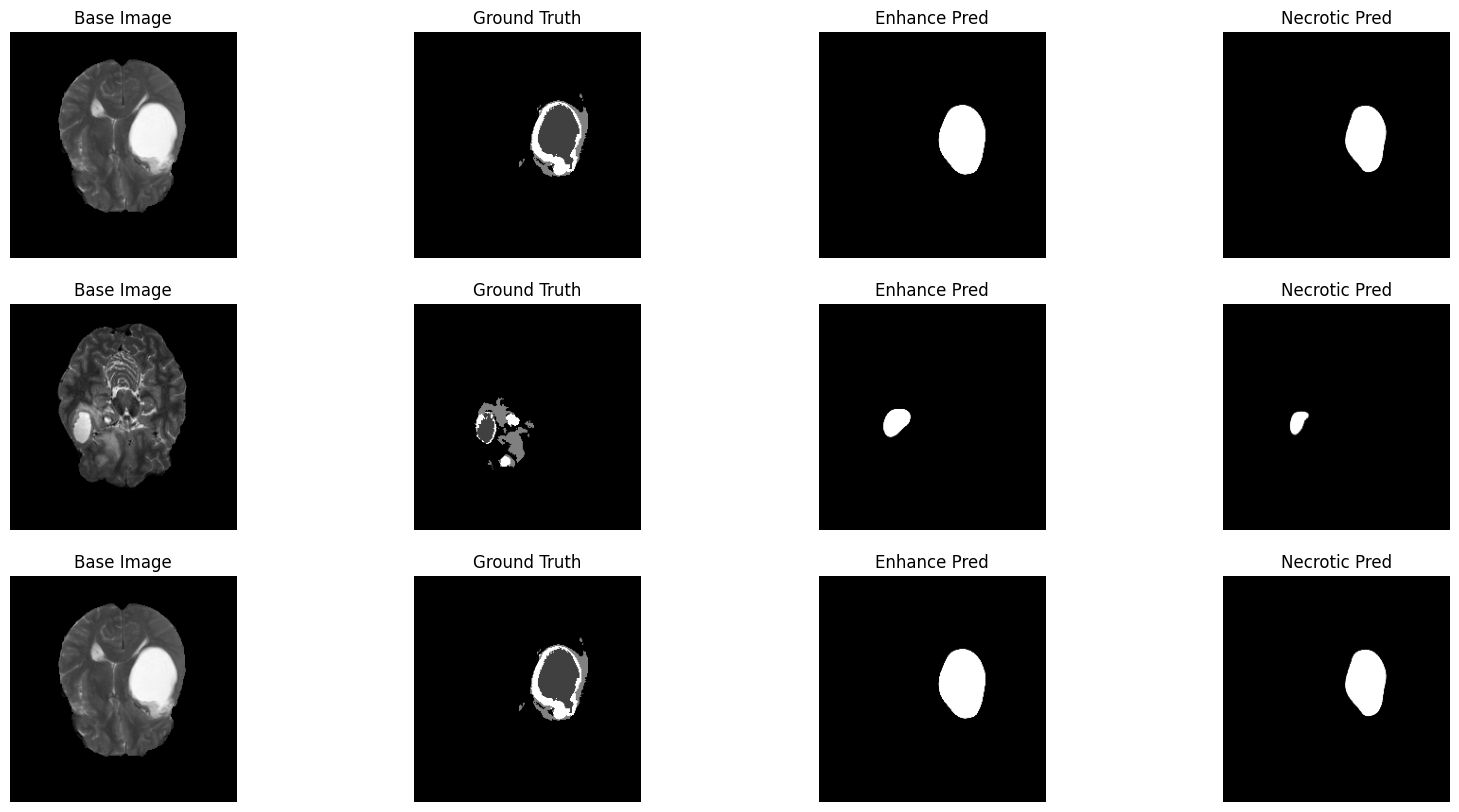

In [93]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],4)
print(pred_candidates)

preds_enhance = model_enhance.predict(validation_vol)
preds_necrotic = model_necrotic.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,3,1):

    plt.subplot(3,4,4*i+1)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap = 'gray')
    plt.title("Base Image")
    plt.axis('off')
    
    plt.subplot(3,4,4*i+2)
    plt.imshow(validl[pred_candidates[i],:,:,0], cmap = 'gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3,4,4*i+3)
    plt.imshow(np.squeeze(preds_enhance[pred_candidates[i]]), cmap = 'gray')
    plt.title("Enhance Pred")
    plt.axis('off')

    plt.subplot(3,4,4*i+4)
    plt.imshow(np.squeeze(preds_necrotic[pred_candidates[i]]), cmap = 'gray')
    plt.title("Necrotic Pred")
    plt.axis('off')